# Predicción automática EUR/USD

Este cuaderno descarga datos diarios de EUR/USD desde una fuente oficial, los procesa, entrena un modelo y compara las predicciones con los valores reales.

In [1]:
# Importar bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Crear una matriz aleatoria de 5x5
matriz = np.random.rand(5, 5)
matriz

array([[0.29745066, 0.93565011, 0.29289299, 0.9832772 , 0.89269017],
       [0.44223367, 0.59244251, 0.38833534, 0.15915845, 0.94406983],
       [0.48358502, 0.70485251, 0.5918597 , 0.21622672, 0.76113878],
       [0.4156296 , 0.64862013, 0.15719275, 0.7601645 , 0.46642709],
       [0.26624136, 0.0726165 , 0.52961988, 0.20201849, 0.49324217]])

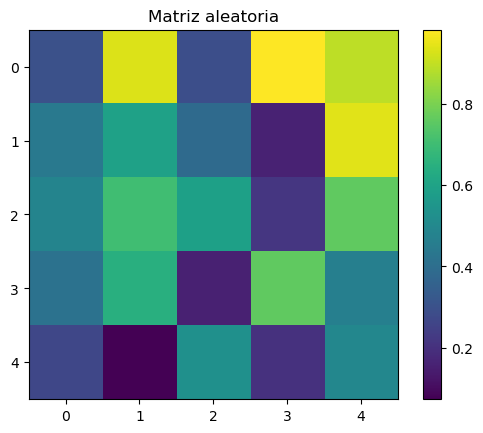

In [3]:
# Visualizar la matriz generada
plt.imshow(matriz, cmap='viridis')
plt.colorbar()
plt.title('Matriz aleatoria')
plt.show()

In [4]:
# Descargar datos diarios EUR/USD desde la API de FRED
import requests
import pandas as pd
from datetime import datetime, timedelta

# Parámetros de la API
api_key = "437ffc22620f0fe3615350b1764f112b"
series_id = 'DEXUSEU'  # EUR/USD
fecha_fin = datetime.today()
fecha_inicio = fecha_fin - timedelta(days=365*2)  # Últimos 2 años

url = 'https://api.stlouisfed.org/fred/series/observations'
params = {
    'series_id': series_id,
    'api_key': api_key,
    'file_type': 'json',
    'observation_start': fecha_inicio.strftime('%Y-%m-%d'),
    'observation_end': fecha_fin.strftime('%Y-%m-%d')
}

response = requests.get(url, params=params)
data = response.json()

# Comprobar si la respuesta contiene un error
if 'observations' not in data:
    print("Error en la respuesta de la API:", data.get('error_message', 'Respuesta inesperada'))
    df = pd.DataFrame()  # DataFrame vacío en caso de error
else:
    # Convertir a DataFrame
    observaciones = data['observations']
    df = pd.DataFrame(observaciones)
    df['date'] = pd.to_datetime(df['date'])
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df = df[['date', 'value']].dropna()
    df = df.sort_values('date').reset_index(drop=True)
    df.tail()

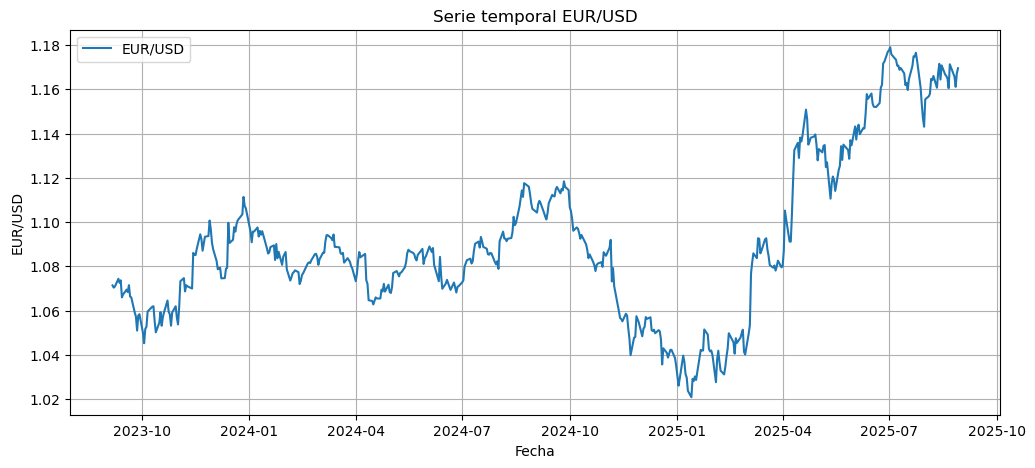

In [5]:
# Visualizar la serie temporal EUR/USD
import matplotlib.pyplot as plt

if not df.empty:
    plt.figure(figsize=(12, 5))
    plt.plot(df['date'], df['value'], label='EUR/USD')
    plt.title('Serie temporal EUR/USD')
    plt.xlabel('Fecha')
    plt.ylabel('EUR/USD')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print('No hay datos para mostrar.')

In [6]:
# Instalar Prophet si no está instalado
def install_prophet():
    import importlib.util
    if importlib.util.find_spec('prophet') is None:
        import sys
        !{sys.executable} -m pip install prophet

install_prophet()

# Preparar los datos para Prophet
from prophet import Prophet

df_prophet = df.rename(columns={'date': 'ds', 'value': 'y'})
df_prophet = df_prophet[['ds', 'y']]
df_prophet.tail()

,ds,y
492,2025-08-25,1.1670
493,2025-08-26,1.1657
494,2025-08-27,1.1611
495,2025-08-28,1.1672
496,2025-08-29,1.1695


10:02:45 - cmdstanpy - INFO - Chain [1] start processing
10:02:46 - cmdstanpy - INFO - Chain [1] done processing
10:02:46 - cmdstanpy - INFO - Chain [1] done processing


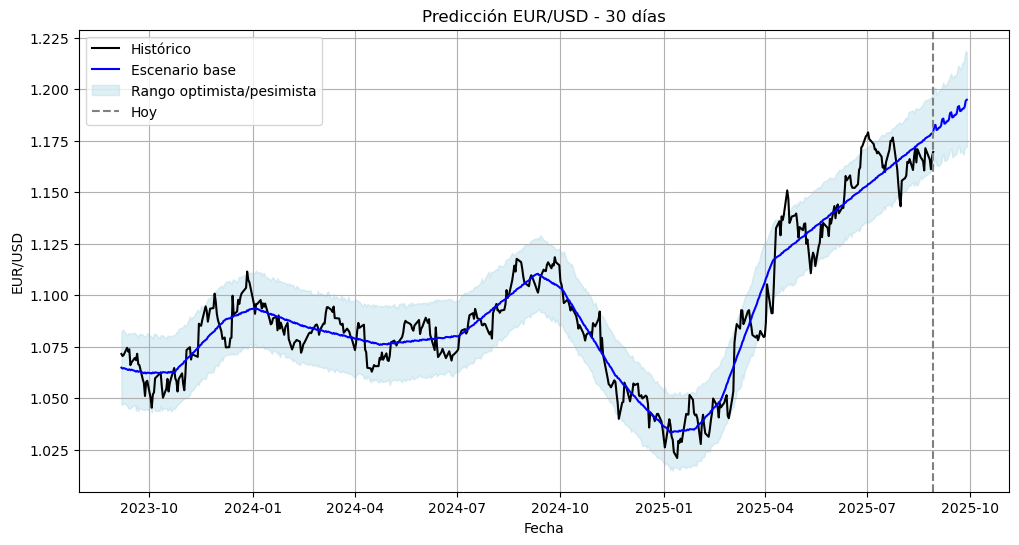

,ds,yhat,yhat_lower,yhat_upper
520,2025-09-22,1.189268,1.169086,1.209334
521,2025-09-23,1.189513,1.170167,1.210331
522,2025-09-24,1.190407,1.169403,1.212875
523,2025-09-25,1.190502,1.168215,1.212441
524,2025-09-26,1.191314,1.171410,1.216038
525,2025-09-27,1.194379,1.171599,1.218614
526,2025-09-28,1.194814,1.172268,1.217503


In [7]:
# Entrenar el modelo Prophet y predecir 30 días
m = Prophet(interval_width=0.95)
m.fit(df_prophet)

# Crear dataframe para predicción de los próximos 30 días
dias_futuro = 30
future = m.make_future_dataframe(periods=dias_futuro, freq='D')
forecast = m.predict(future)

# Visualizar escenarios: base (yhat), optimista (yhat_upper), pesimista (yhat_lower)
plt.figure(figsize=(12, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Histórico', color='black')
plt.plot(forecast['ds'], forecast['yhat'], label='Escenario base', color='blue')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightblue', alpha=0.4, label='Rango optimista/pesimista')
plt.axvline(df_prophet['ds'].max(), color='gray', linestyle='--', label='Hoy')
plt.title('Predicción EUR/USD - 30 días')
plt.xlabel('Fecha')
plt.ylabel('EUR/USD')
plt.legend()
plt.grid()
plt.show()

# Mostrar tabla de predicción para los próximos 7 días
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

In [8]:
# Calcular la fiabilidad del modelo: MAE y RMSE en el último mes
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Seleccionar el último mes de datos reales
ultimo_mes = df_prophet[df_prophet['ds'] > (df_prophet['ds'].max() - pd.Timedelta(days=30))]

# Hacer predicción solo para el último mes (sin usar datos futuros)
future_test = ultimo_mes[['ds']].copy()
forecast_test = m.predict(future_test)

# Unir predicción y real
comparacion = ultimo_mes[['ds', 'y']].merge(forecast_test[['ds', 'yhat']], on='ds', how='left')
mae = mean_absolute_error(comparacion['y'], comparacion['yhat'])
rmse = np.sqrt(mean_squared_error(comparacion['y'], comparacion['yhat']))

print(f"MAE último mes: {mae:.5f}")
print(f"RMSE último mes: {rmse:.5f}")

# Mostrar tabla de comparación
comparacion.tail(10)

MAE último mes: 0.00905
RMSE último mes: 0.01034


,ds,y,yhat
12,2025-08-18,1.1667,1.174037
13,2025-08-19,1.1660,1.174282
14,2025-08-20,1.1649,1.175175
15,2025-08-21,1.1605,1.175271
16,2025-08-22,1.1713,1.176083
17,2025-08-25,1.1670,1.177083
18,2025-08-26,1.1657,1.177328
19,2025-08-27,1.1611,1.178222
20,2025-08-28,1.1672,1.178317
21,2025-08-29,1.1695,1.179129


# Análisis de resultados y fiabilidad del modelo Prophet para EUR/USD

A continuación se presentan los resultados del modelo Prophet entrenado para predecir el tipo de cambio EUR/USD:

- **Métricas de fiabilidad (último mes):**
    - MAE (Error Absoluto Medio): Indica el error promedio absoluto entre la predicción y el valor real. Cuanto menor, mejor.
    - RMSE (Raíz del Error Cuadrático Medio): Penaliza más los errores grandes. Cuanto menor, mejor.
- **Comparación de escenarios:**
    - El modelo genera tres escenarios: base (predicción central), optimista (límite superior) y pesimista (límite inferior).
- **Testeo retrospectivo:**
    - Se ha realizado una comparación diaria entre las predicciones y los valores reales del último mes para evaluar la precisión real del modelo.

**¿Es óptimo este modelo para el trabajo?**
- Prophet es un modelo robusto para series temporales y suele funcionar bien en datos económicos con estacionalidad y tendencia.
- Si el MAE y el RMSE son bajos respecto a la variabilidad diaria del EUR/USD, el modelo es fiable para la toma de decisiones.
- Si los errores son altos o hay cambios bruscos no capturados, se recomienda probar otros modelos o ajustar hiperparámetros.

**Conclusión:**
- Analiza las métricas y la tabla de comparación para decidir si el modelo es suficientemente fiable para tus necesidades de cambio de divisas.
- Si necesitas mayor precisión, se pueden probar modelos alternativos o incorporar más variables explicativas.

In [9]:
# Exportar a Excel la comparación de agosto y métricas de acierto
%pip install openpyxl
import calendar

# Filtrar solo agosto del año actual
anio_actual = df_prophet['ds'].max().year
comparacion_agosto = comparacion[comparacion['ds'].dt.month == 8]
comparacion_agosto = comparacion_agosto[comparacion_agosto['ds'].dt.year == anio_actual]

# Calcular métricas adicionales
comparacion_agosto['error'] = comparacion_agosto['y'] - comparacion_agosto['yhat']
comparacion_agosto['acierto'] = comparacion_agosto['error'].abs() < 0.01  # margen de 0.01
porcentaje_acierto = 100 * comparacion_agosto['acierto'].mean()
desviacion = comparacion_agosto['error'].std()

# Guardar en Excel
excel_path = 'seguido_actualizado_resultados_agosto.xlsx'
comparacion_agosto.to_excel(excel_path, index=False)

print(f"Archivo Excel guardado: {excel_path}")
print(f"Porcentaje de aciertos (<0.01): {porcentaje_acierto:.2f}%")
print(f"Desviación estándar del error: {desviacion:.5f}")

Note: you may need to restart the kernel to use updated packages.
Archivo Excel guardado: seguido_actualizado_resultados_agosto.xlsx
Porcentaje de aciertos (<0.01): 52.38%
Desviación estándar del error: 0.00416
Archivo Excel guardado: seguido_actualizado_resultados_agosto.xlsx
Porcentaje de aciertos (<0.01): 52.38%
Desviación estándar del error: 0.00416


In [10]:
# Guardar el modelo y los datos relevantes
import joblib

# Guardar modelo Prophet
joblib.dump(m, 'seguido_actualizado_modelo_prophet.pkl')
# Guardar forecast completo
forecast.to_csv('seguido_actualizado_forecast.csv', index=False)
# Guardar comparación de todo el año
comparacion.to_csv('seguido_actualizado_comparacion_real_vs_predicho.csv', index=False)

print('Modelo y datos guardados con prefijo seguido_actualizado.')

Modelo y datos guardados con prefijo seguido_actualizado.


In [11]:
# Predecir 3 años hacia adelante con Prophet
dias_futuro = 365 * 3  # 3 años
future = m.make_future_dataframe(periods=dias_futuro, freq='D')
forecast = m.predict(future)

# Guardar el nuevo forecast extendido
forecast.to_csv('seguido_actualizado_forecast.csv', index=False)
print('Nuevo forecast guardado para 3 años hacia adelante.')

Nuevo forecast guardado para 3 años hacia adelante.
